 <h1 align="center"> Online Payment Fraud Detection System:</h1>

<h2 align="center"> A Data-Driven Machine Learning Project </h2>

### Introduction:
This project is a machine learning classification model to detect fraudulent transactions in online payments. The dataset used is highly imbalanced, with far more non-fraudulent transactions than fraudulent ones. The project explores multiple algorithms and techniques to address the imbalance and improve the detection of fraud.

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import  confusion_matrix, classification_report, roc_auc_score,roc_curve,auc

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
np.set_printoptions(suppress=True)

import warnings
warnings.filterwarnings('ignore')  # To suppress warnings


# Data Loading and Analyzing:

In [44]:
df = pd.read_csv('dataset.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,11,PAYMENT,23824.85,C689938949,0.00,0.00,M1460872626,0.00,0.00,0,0
1,9,PAYMENT,21635.32,C1575214500,81920.49,60285.17,M266977218,0.00,0.00,0,0
2,12,CASH_IN,351121.91,C995443509,4454306.27,4805428.19,C2115498160,1479790.46,1231184.66,0,0
3,9,CASH_IN,58429.17,C2059144571,6544514.05,6602943.22,C1137371968,4724976.11,6392871.31,0,0
4,8,CASH_OUT,119846.49,C1702593733,0.00,0.00,C1898859288,605241.14,896323.73,0,0


In [45]:
print("Rows and Columns")
print(df.shape)

Rows and Columns
(58213, 11)


##### Columns




#### Class imbalance 

In [46]:
# We have class imbalance in the Fraudulent(1) transactions.
print(df['isFraud'].value_counts())
df['isFraud'].value_counts(normalize=True)

isFraud
0    50000
1     8213
Name: count, dtype: int64


isFraud
0   0.86
1   0.14
Name: proportion, dtype: float64

In [47]:
# Renaming columns:

print(df.columns)
df.rename(columns={'type':'transaction_type'},inplace=True)
df.rename(columns={'step':'time'},inplace=True)
print(df.columns)

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')
Index(['time', 'transaction_type', 'amount', 'nameOrig', 'oldbalanceOrg',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')


In [48]:
df.describe()

,time,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,58213.00,58213.00,58213.00,58213.00,58213.00,58213.00,58213.00,58213.00
mean,60.64,363006.89,983423.96,794276.51,880485.19,1198193.47,0.14,0.00
std,148.89,1053104.63,2885794.95,2694626.75,2515157.13,2843751.21,0.35,0.02
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,9.00,14426.04,0.00,0.00,0.00,0.00,0.00,0.00
50%,11.00,97133.63,31223.00,0.00,20640.00,114827.36,0.00,0.00
75%,12.00,282111.84,347735.10,148390.13,664408.32,1177760.30,0.00,0.00
max,743.00,10000000.00,59585040.37,49585040.37,236230516.82,236726494.66,1.00,1.00


In [49]:
# Converting Step to hour of day:
df['time'] = df['time'] % 24
print(df['time'].dtype)
df['time'].unique()

int64


array([11,  9, 12,  8,  3, 10, 13,  7,  5,  6,  1,  2,  4, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23,  0], dtype=int64)

In [50]:
numeric_columns = df.select_dtypes(['int64','float64']).columns

df[numeric_columns] = df[numeric_columns].astype('int')
df[numeric_columns].head(3)

,time,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,11,23824,0,0,0,0,0,0
1,9,21635,81920,60285,0,0,0,0
2,12,351121,4454306,4805428,1479790,1231184,0,0


In [51]:
cat_column = ['transaction_type','isFraud','isFlaggedFraud']

for col in cat_column:
    print(f"column => {col} = {df[col].unique()}")

column => transaction_type = ['PAYMENT' 'CASH_IN' 'CASH_OUT' 'TRANSFER' 'DEBIT']
column => isFraud = [0 1]
column => isFlaggedFraud = [0 1]


#### Features:

## Data Cleaning

In [52]:
print("Checking for NA Values")
print(df.isna().sum())

Checking for NA Values
time                0
transaction_type    0
amount              0
nameOrig            0
oldbalanceOrg       0
newbalanceOrig      0
nameDest            0
oldbalanceDest      0
newbalanceDest      0
isFraud             0
isFlaggedFraud      0
dtype: int64


In [53]:
print("Checking for Duplicates")
print(df.duplicated().sum())

Checking for Duplicates
0


In [54]:
df[numeric_columns].describe()

,time,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,58213.00,58213.00,58213.00,58213.00,58213.00,58213.00,58213.00,58213.00
mean,10.29,363006.40,983423.77,794276.31,880484.96,1198193.20,0.14,0.00
std,3.28,1053104.65,2885794.86,2694626.66,2515157.04,2843751.12,0.35,0.02
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,9.00,14426.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,10.00,97133.00,31223.00,0.00,20640.00,114827.00,0.00,0.00
75%,12.00,282111.00,347735.00,148390.00,664408.00,1177760.00,0.00,0.00
max,23.00,10000000.00,59585040.00,49585040.00,236230516.00,236726494.00,1.00,1.00


### Analyze categorical features

In [55]:
df.select_dtypes(exclude=['float64','int64']).columns

categorical_columns = df.select_dtypes(exclude=['float64','int']).columns[0] # We will only use transaction type column as categorical because the other columns are unique identifiers.
categorical_columns

'transaction_type'

In [56]:
# Unique Identifers:
df[['nameOrig','nameDest']].describe()

,nameOrig,nameDest
count,58213,58213
unique,58213,40042
top,C689938949,C451111351
freq,1,21


# Exploratory Data Analysis

In [57]:
numeric_columns

Index(['time', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [58]:
categorical_columns

'transaction_type'

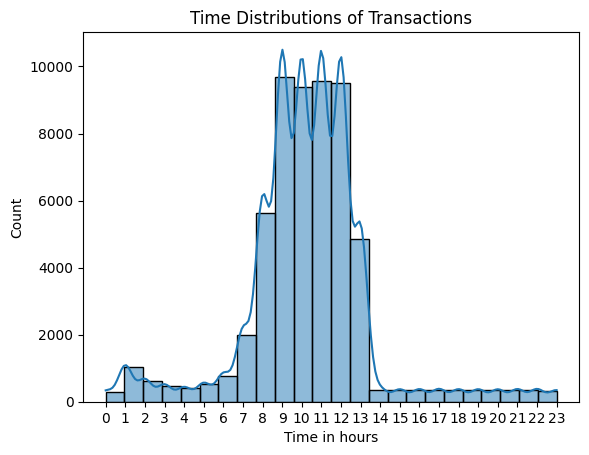

In [60]:
sns.histplot(data=df,x='time',bins=24,kde=True)

plt.xlabel("Time in hours")
plt.title("Time Distributions of Transactions")
plt.xticks(range(0, 24))  # Show all 24 hours on x-axis
plt.show()

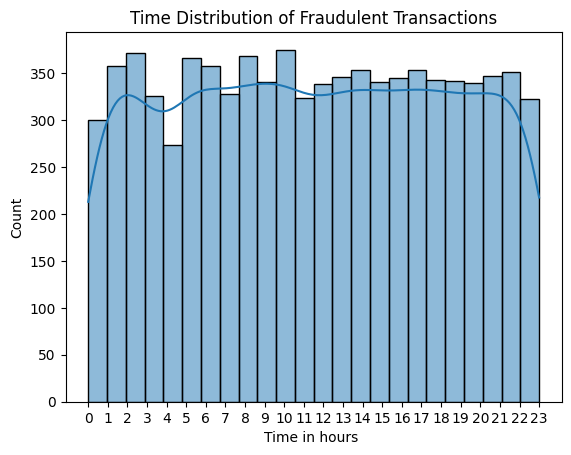

In [62]:
fraud_df = df[df['isFraud'] == 1] 

sns.histplot(data=fraud_df, x='time', bins=24, kde=True)  # Using 24 bins for 24 hours

plt.xlabel("Time in hours ")
plt.title("Time Distribution of Fraudulent Transactions")
plt.xticks(range(0, 24))  # Show all 24 hours on x-axis
plt.show()

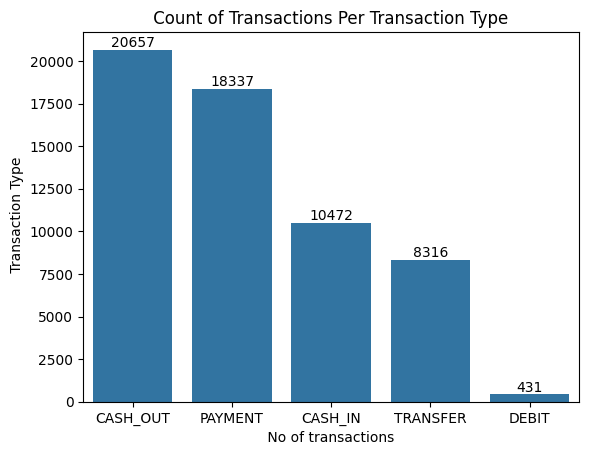

In [63]:
transaction_count = df.groupby('transaction_type')['isFraud'].count().reset_index(name='no of transactions') \
   .sort_values(by='no of transactions',ascending=False)

ax = sns.barplot(data=transaction_count,x='transaction_type',y='no of transactions',)
ax.bar_label(ax.containers[0])

plt.xlabel(" No of transactions ")
plt.title(" Count of Transactions Per Transaction Type ")
plt.ylabel(" Transaction Type")
plt.show()

### Insights

1. Majority of the Transactions were done By Payment and Cash_out Mode.
2. Very less transactions were done by Debit and transfer type.

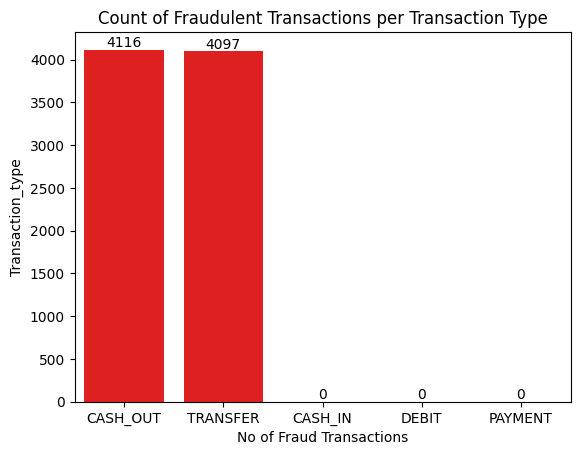

In [64]:
fraud_count_df = df.groupby('transaction_type')['isFraud'].sum().reset_index() \
     .sort_values(by='isFraud',ascending=False) 

ax = sns.barplot(data=fraud_count_df,x='transaction_type',y='isFraud',color='red')
ax.bar_label(ax.containers[0])

plt.title("Count of Fraudulent Transactions per Transaction Type")
plt.xlabel("No of Fraud Transactions")
plt.ylabel("Transaction_type")
plt.show()

### Insights

1. Majortiy of the Fraudulent transaction's were either by (CASH OUT) withdrawal of money from the account or by Transfer of funds between two accounts (TRANSFER).
2. No Fraudulent Transactions were done by any other type.

In [65]:
numeric_columns

Index(['time', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

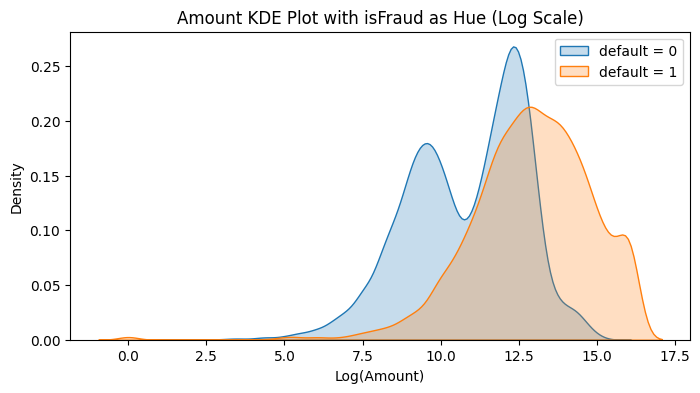

In [66]:
plt.figure(figsize=(8, 4))
sns.kdeplot(np.log1p(df['amount'][df['isFraud'] == 0]), fill=True, label='default = 0')
sns.kdeplot(np.log1p(df['amount'][df['isFraud'] == 1]), fill=True, label='default = 1')
plt.title("Amount KDE Plot with isFraud as Hue (Log Scale)")
plt.xlabel("Log(Amount)")
plt.legend()
plt.show()

#### Insights:

1. We can see that Transactions with higher amount have chances of beign FRAUDULENT.
2. Transactions with smaller amount tend to being NON-FRAUDULENT

### Co-relation matrix:

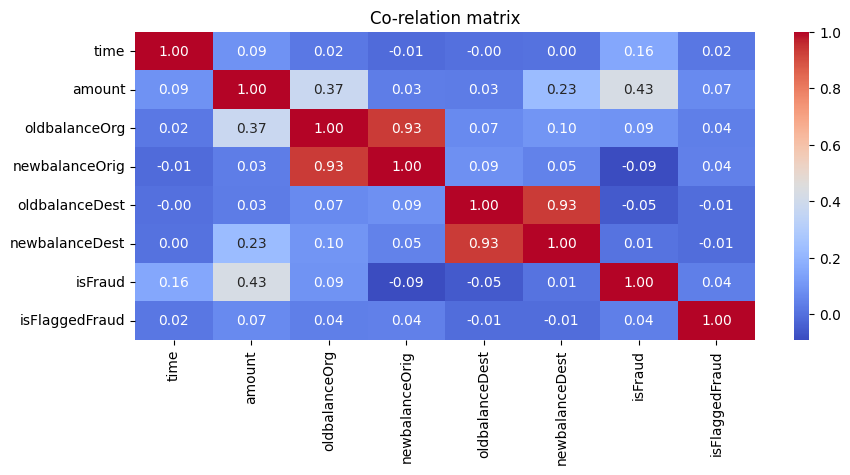

In [67]:
cm = df[numeric_columns].corr()

plt.figure(figsize=(10,4))
sns.heatmap(cm,annot=True,fmt=".2f",cmap='coolwarm')
plt.title("Co-relation matrix")
plt.show()

### Insights from EDA.

1. Most of the transactions took place by CASH OUT , PAYMENT and CASH IN
2. Majority of the FRAUDULENT Transactions took place by CASH OUT or TRANSFER Transaction Type
3. Higher the Amount of Transaction, Higher the Risk of it being Fraud.


# Feature Engineering , Feature Selection

In [68]:
df.head(2)

,time,transaction_type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,11,PAYMENT,23824,C689938949,0,0,M1460872626,0,0,0,0
1,9,PAYMENT,21635,C1575214500,81920,60285,M266977218,0,0,0,0


#### Removing columns based on Domain knowledge

In [69]:
df.drop(columns=['nameOrig','nameDest','isFlaggedFraud','oldbalanceDest','newbalanceDest'],inplace=True)
df.head(2)

,time,transaction_type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,11,PAYMENT,23824,0,0,0
1,9,PAYMENT,21635,81920,60285,0


# Feature Encoding:
Encoding transaction type column using label encoding:

In [70]:
df['transaction_type'] = df['transaction_type'].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})

print(df['transaction_type'].unique())

[2 3 1 4 5]


In [71]:
df.head(2)

,time,transaction_type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,11,2,23824,0,0,0
1,9,2,21635,81920,60285,0


# Model Training

#### Train Test Split

In [104]:
X = df[['time','transaction_type','amount','oldbalanceOrg','newbalanceOrig']]
y = df['isFraud']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

### Attempt 1:


##### Without handling Class Imbalance

In [105]:
# Custom function that takes model, train and test data and returns a classification report.

def get_report(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test,y_pred) 
    
    print(report)

In [ ]:
# get_report(LogisticRegression(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     14941
           1       0.90      0.71      0.79      2523

    accuracy                           0.95     17464
   macro avg       0.93      0.85      0.88     17464
weighted avg       0.94      0.95      0.94     17464



In [ ]:
# get_report(DecisionTreeClassifier(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14941
           1       0.98      0.98      0.98      2523

    accuracy                           0.99     17464
   macro avg       0.99      0.99      0.99     17464
weighted avg       0.99      0.99      0.99     17464



In [ ]:
# get_report(RandomForestClassifier(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14941
           1       0.98      0.99      0.98      2523

    accuracy                           0.99     17464
   macro avg       0.99      0.99      0.99     17464
weighted avg       0.99      0.99      0.99     17464



### Insights:

LogiticRegression Model : recall = 0.53 , precision = 0.98

DecsionTreeClassifier Model : recall = 0.96 , precision =0.98

RandomForestClassfier Model : recall = 0.96, precision = 0.99

## Attempt 2:

#### Handling Class Imbalance using Smote, RandomUnderSampler Techniques:

#### Using SMOTE

In [78]:
from imblearn.over_sampling import SMOTE

In [79]:
smt = SMOTE(random_state=42)

X_resampled,y_resampled = smt.fit_resample(X,y)

In [ ]:
# get_report(LogisticRegression(),X_resampled,y_resampled,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     14941
           1       0.54      0.99      0.70      2523

    accuracy                           0.88     17464
   macro avg       0.77      0.93      0.81     17464
weighted avg       0.93      0.88      0.89     17464



In [ ]:
get_report(DecisionTreeClassifier(),X_resampled,y_resampled,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14941
           1       1.00      1.00      1.00      2523

    accuracy                           1.00     17464
   macro avg       1.00      1.00      1.00     17464
weighted avg       1.00      1.00      1.00     17464



In [82]:
get_report(RandomForestClassifier(),X_resampled,y_resampled,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14941
           1       1.00      1.00      1.00      2523

    accuracy                           1.00     17464
   macro avg       1.00      1.00      1.00     17464
weighted avg       1.00      1.00      1.00     17464



#### Using RandomUnderSampler:

In [83]:
from imblearn.under_sampling import RandomUnderSampler

In [84]:
under_sampler= RandomUnderSampler(random_state=42)

X_under,y_under = under_sampler.fit_resample(X,y)

In [85]:
get_report(LogisticRegression(),X_under,y_under,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     14941
           1       0.53      0.99      0.69      2523

    accuracy                           0.87     17464
   macro avg       0.77      0.92      0.81     17464
weighted avg       0.93      0.87      0.89     17464



In [86]:
get_report(DecisionTreeClassifier(),X_under,y_under,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14941
           1       0.97      1.00      0.98      2523

    accuracy                           1.00     17464
   macro avg       0.98      1.00      0.99     17464
weighted avg       1.00      1.00      1.00     17464



In [87]:
get_report(RandomForestClassifier(),X_under,y_under,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14941
           1       0.96      1.00      0.98      2523

    accuracy                           0.99     17464
   macro avg       0.98      1.00      0.99     17464
weighted avg       0.99      0.99      0.99     17464



## Model Fine Tuning:

1. Finalized Random Forest Classifier Model with hyperparameters:

In [112]:
get_report( RandomForestClassifier(n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=10,
    max_features='sqrt',
    class_weight={0: 1, 1: 5},  
    random_state=42), X_train,y_train,X_test,y_test ) 


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14941
           1       0.94      0.99      0.97      2523

    accuracy                           0.99     17464
   macro avg       0.97      0.99      0.98     17464
weighted avg       0.99      0.99      0.99     17464



In [113]:
best_model = RandomForestClassifier(n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=10,
    max_features='sqrt',
    class_weight={0: 1, 1: 5},  
    random_state=42)

best_model.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 5}, max_depth=10,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [114]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14941
           1       0.94      0.99      0.97      2523

    accuracy                           0.99     17464
   macro avg       0.97      0.99      0.98     17464
weighted avg       0.99      0.99      0.99     17464



### --- Our Best model is RandomForestClassifier with recall 99% and precision 94% --- 

## Model Evaluation Roc,Auc Curve:

In [115]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
fpr[:5], tpr [:5],thresholds[:5]

(array([0.        , 0.01017335, 1.        ]),
 array([0.       , 0.9940547, 1.       ]),
 array([2, 1, 0]))

In [116]:
auc_score = auc(fpr,tpr)
print(f"Area Under the Curve = {round(auc_score,2)}")

Area Under the Curve = 0.99


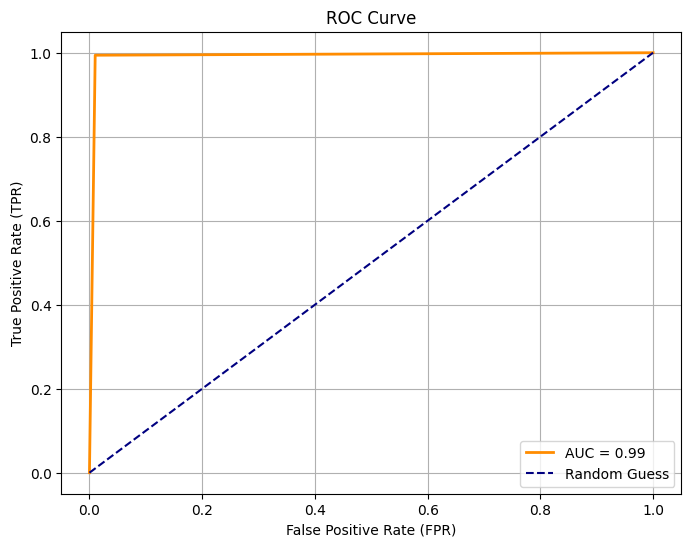

In [117]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### Manual Inputs for checking the working of the model:

In [120]:
df.query('isFraud ==1 and newbalanceOrig != 0').head(5)

,time,transaction_type,amount,oldbalanceOrg,newbalanceOrig,isFraud
50028,4,4,10000000,12930418,2930418,1
50104,9,4,994453,1437370,442917,1
50203,17,1,42062,340830,298767,1
50227,19,4,10000000,11861008,1861008,1
50353,9,4,10000000,19887819,9887819,1


In [135]:
value = best_model.predict([[4,4,10000000,12930418,2930418]])
probability = best_model.predict_proba([[4,4,10000000,12930418,2930418]])
print(value,probability[0][1])
if value == 0:
    print("Not a Fraud")
else:
    print("Fraud")    

[1] 0.9933542409624398
Fraud


#### Dumping the Model and its Artifcats:

In [137]:
import joblib

model_data = {
    'model':best_model,
    'features':X_train.columns,
    'label_mapping': {0: 'Not Fraud', 1: 'Fraud'} 
}

joblib.dump(model_data,'fraud_detection_model.pkl')

['fraud_detection_model.pkl']